
# NSE Swing Trading — Unsupervised Clustering (TA-Lib Feature Space)

This notebook groups **NSE stocks** by similarity in **technical indicator behavior** (RSI, MACD, ATR, Bollinger Bands, MAs, momentum, volatility, etc.) using **unsupervised learning** (KMeans / DBSCAN / Hierarchical).  
The goal is to **filter stocks** that belong to the most "swing-friendly" clusters (i.e., adequate volatility, oscillatory behavior, and tradable momentum/mean-reversion characteristics).

**What you get:**
- Download daily OHLCV with `yfinance`
- Compute indicators with **TA-Lib** (with a fallback to `pandas_ta` if TA-Lib is unavailable)
- Build aggregated **feature vectors** per stock over a recent lookback window
- Run **KMeans**, **DBSCAN**, or **Agglomerative (hierarchical)** clustering
- **Score clusters** with a transparent heuristic for swing trading suitability
- **Visualize** clusters in PCA/t-SNE space + indicator distributions by cluster (pure matplotlib)
- Export filtered stocks to **CSV** with `[Stock, Cluster, Key_Indicators]`

> **Note:** This is **not** a return predictor. It simply groups stocks by behavior. You can feed the resulting CSV into your own backtesting / signal engine.



## 0. Setup

Run the cell below **once** to install dependencies if needed.  
(If you already have them, you can skip or comment it out.)


In [12]:

# !pip install --upgrade pip
# !pip install yfinance pandas numpy scipy scikit-learn matplotlib
# # TA-Lib options:
# # 1) If your OS has TA-Lib C library installed:
# #    pip install TA-Lib
# # 2) If not, you can use a prebuilt wheel (depends on your platform), or a fallback:
# #    pip install pandas-ta
#
# # On macOS with brew:
# #   brew install ta-lib && pip install TA-Lib
# # On Ubuntu/Debian:
# #   sudo apt-get update && sudo apt-get install -y build-essential wget
# #   wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# #   tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib
# #   ./configure --prefix=/usr && make && sudo make install && cd ..
# #   pip install TA-Lib



## 1. Configuration

Edit the tickers, dates, and clustering method here.


In [13]:

from datetime import datetime
from pathlib import Path

# ------------------- USER CONFIG (Edit this) -------------------
STOCKS = ['ABB.NS', 'ADANIENSOL.NS', 'ADANIGREEN.NS', 'ADANIPOWER.NS', 'AMBUJACEM.NS', 'DMART.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BANKBARODA.NS', 'BPCL.NS', 'BOSCHLTD.NS', 'BRITANNIA.NS', 'CGPOWER.NS', 'CANBK.NS', 'CHOLAFIN.NS', 'DLF.NS', 'DABUR.NS', 'DIVISLAB.NS', 'GAIL.NS', 'GODREJCP.NS', 'HAVELLS.NS', 'HAL.NS', 'HYUNDAI.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'INDHOTEL.NS', 'IOC.NS', 'IRFC.NS', 'NAUKRI.NS', 'INDIGO.NS', 'JSWENERGY.NS', 'JINDALSTEL.NS', 'LTIM.NS', 'LICI.NS', 'LODHA.NS', 'PIDILITIND.NS', 'PFC.NS', 'PNB.NS', 'RECLTD.NS', 'MOTHERSON.NS', 'SHREECEM.NS', 'SIEMENS.NS', 'SWIGGY.NS', 'TVSMOTOR.NS', 'TATAPOWER.NS', 'TORNTPHARM.NS', 'UNITDSPR.NS', 'VBL.NS', 'VEDL.NS', 'ZYDUSLIFE.NS']

START_DATE = "2018-01-01"
END_DATE   = None  # until today
LOOKBACK_DAYS = 180   # rolling window for aggregated features

# Clustering choice: 'kmeans', 'dbscan', or 'agglo'
CLUSTERING = "agglo"

# KMeans params
N_CLUSTERS = 6
KMEANS_RANDOM_STATE = 42
KMEANS_N_INIT = 10

# DBSCAN params (work on scaled space)
DBSCAN_EPS = 1.4
DBSCAN_MIN_SAMPLES = 3

# Agglomerative params
AGGLO_N_CLUSTERS = 6
AGGLO_LINKAGE = "ward"  # 'ward', 'complete', 'average', 'single'

# Selection
TOP_N_CLUSTERS = 2  # number of "swing-friendly" clusters to select

# Output
OUTPUT_CSV = "swing_friendly_stocks.csv"
OUTDIR = Path("outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------



## 2. Imports


In [14]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import yfinance as yf

# Try TA-Lib; if unavailable, soft-fallback to pandas_ta
try:
    import talib as ta
    TA_BACKEND = "talib"
except Exception:
    TA_BACKEND = None
    try:
        import pandas_ta as pta
        TA_BACKEND = "pandas_ta"
    except Exception:
        TA_BACKEND = None

from scipy.stats import zscore

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", 200)



## 3. Utility Functions — Indicators, Features, Clustering


In [15]:

def _require_ta_lib():
    if TA_BACKEND is None:
        raise ImportError(
            "Neither TA-Lib nor pandas_ta found. Please install TA-Lib "
            "(preferred) or pandas_ta as fallback."
        )

def compute_indicators(df):
    '''
    Compute technical indicators for a single-ticker OHLCV DataFrame.
    df columns must include: ['Open','High','Low','Close','Volume']
    Returns DataFrame with extra columns.
    Uses TA-Lib if available, otherwise pandas_ta.
    '''
    _require_ta_lib()

    out = df.copy()

    if TA_BACKEND == "talib":
        # Core indicators
        out["RSI14"] = ta.RSI(out["Close"], timeperiod=14)
        macd, macdsig, macdhist = ta.MACD(out["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
        out["MACD"] = macd
        out["MACDsig"] = macdsig
        out["MACDhist"] = macdhist
        out["ATR14"] = ta.ATR(out["High"], out["Low"], out["Close"], timeperiod=14)
        ub, mb, lb = ta.BBANDS(out["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        out["BB_upper"] = ub
        out["BB_mid"]   = mb
        out["BB_lower"] = lb
        out["SMA20"] = ta.SMA(out["Close"], timeperiod=20)
        out["SMA50"] = ta.SMA(out["Close"], timeperiod=50)
        out["MOM10"] = ta.MOM(out["Close"], timeperiod=10)
        out["ADX14"] = ta.ADX(out["High"], out["Low"], out["Close"], timeperiod=14)

    elif TA_BACKEND == "pandas_ta":
        out["RSI14"] = pta.rsi(out["Close"], length=14)
        macd_df = pta.macd(out["Close"], fast=12, slow=26, signal=9)
        out["MACD"] = macd_df["MACD_12_26_9"]
        out["MACDsig"] = macd_df["MACDs_12_26_9"]
        out["MACDhist"] = macd_df["MACDh_12_26_9"]
        out["ATR14"] = pta.atr(out["High"], out["Low"], out["Close"], length=14)
        bb = pta.bbands(out["Close"], length=20, std=2)
        out["BB_upper"] = bb["BBU_20_2.0"]
        out["BB_mid"]   = bb["BBM_20_2.0"]
        out["BB_lower"] = bb["BBL_20_2.0"]
        out["SMA20"] = pta.sma(out["Close"], length=20)
        out["SMA50"] = pta.sma(out["Close"], length=50)
        out["MOM10"] = pta.mom(out["Close"], length=10)
        out["ADX14"] = pta.adx(out["High"], out["Low"], out["Close"], length=14)["ADX_14"]

    # Extra derived metrics
    out["RET_1"] = out["Close"].pct_change(1)
    out["RET_5"] = out["Close"].pct_change(5)
    out["RET_20"] = out["Close"].pct_change(20)
    out["ATR_pct"] = out["ATR14"] / out["Close"]
    out["BB_bw"] = (out["BB_upper"] - out["BB_lower"]) / out["Close"]
    out["MA20_SLOPE"] = out["SMA20"].diff(1)
    out["MA20_SLOPE_NORM"] = out["MA20_SLOPE"] / out["Close"]

    # Simple CHOP index (range vs travel) over 14 bars
    # CHOP ~ high log value => choppier (range-bound). lower => trendier.
    n = 14
    tr = np.maximum(out["High"] - out["Low"], np.maximum(abs(out["High"] - out["Close"].shift()), abs(out["Low"] - out["Close"].shift())))
    sum_tr = tr.rolling(n).sum()
    hh = out["High"].rolling(n).max()
    ll = out["Low"].rolling(n).min()
    chop = 100 * np.log10(sum_tr / (hh - ll)) / np.log10(n)
    out["CHOP14"] = chop.replace([np.inf, -np.inf], np.nan)

    return out


def aggregate_features(ind, lookback=180):
    '''
    Aggregate per-stock indicators over a recent lookback window into
    a single feature vector for clustering.
    Returns a dict of features.
    '''
    recent = ind.tail(lookback).dropna()

    if recent.empty:
        return None

    feats = {}
    # Volatility & range
    feats["ATR_pct_mean"] = recent["ATR_pct"].mean()
    feats["ATR_pct_std"]  = recent["ATR_pct"].std()
    feats["BB_bw_mean"]   = recent["BB_bw"].mean()

    # Momentum / trend
    feats["RET_20_mean"]  = recent["RET_20"].mean()
    feats["RET_60"]       = ind["Close"].pct_change(60).iloc[-1] if len(ind) >= 61 else np.nan
    feats["MA20_SLOPE_NORM_mean"] = recent["MA20_SLOPE_NORM"].mean()
    feats["ADX14_mean"]   = recent["ADX14"].mean()

    # Oscillation (mean-reversion potential proxy)
    feats["RSI14_mean"]   = recent["RSI14"].mean()
    feats["RSI14_std"]    = recent["RSI14"].std()
    # How often RSI crosses midline (50) — proxy for oscillation
    rsi = recent["RSI14"].dropna()
    feats["RSI_cross_rate"] = ((rsi.shift(1) - 50) * (rsi - 50) < 0).sum() / max(1, len(rsi))

    # Returns distribution
    r = recent["RET_1"].dropna()
    feats["RET_1_std"]   = r.std()
    feats["RET_1_skew"]  = r.skew()
    feats["RET_1_kurt"]  = r.kurt()

    # Price proximity to MA (how mean-reverting around MA20 the series is)
    resid = (recent["Close"] - recent["SMA20"]) / recent["Close"]
    feats["MA20_resid_std"] = resid.std()

    # Last (for Key_Indicators string later)
    feats["last_ATR_pct"] = ind["ATR_pct"].iloc[-1]
    feats["last_RSI14"]   = ind["RSI14"].iloc[-1]
    feats["last_BB_bw"]   = ind["BB_bw"].iloc[-1]
    feats["last_ADX14"]   = ind["ADX14"].iloc[-1]
    feats["last_RET_20"]  = ind["RET_20"].iloc[-1]

    return feats


def score_clusters(feature_df, labels):
    '''
    Produce a cluster-level summary and a composite 'swing_score' using z-scored columns.
    Higher score => more swing-friendly: adequate volatility, oscillation, tradable ranges.
    Penalizes very strong trend (high ADX or large MA20 slope magnitude).
    '''
    df = feature_df.copy()
    df["Cluster"] = labels

    agg = df.groupby("Cluster").mean(numeric_only=True)

    # Columns to use in scoring
    pos_cols = ["ATR_pct_mean", "RSI14_std", "BB_bw_mean", "RET_1_std", "RSI_cross_rate", "MA20_resid_std"]
    neg_cols = ["ADX14_mean", "MA20_SLOPE_NORM_mean", "RET_60"]  # too strong trend 
    for c in pos_cols + neg_cols:
        if c not in agg.columns:
            agg[c] = np.nan

    # z-score within clusters (column-wise), ignoring NaNs
    z = agg.apply(lambda col: (col - np.nanmean(col)) / (np.nanstd(col) + 1e-9))

    swing_score = (
        + 1.00 * z.get("ATR_pct_mean", 0)
        + 0.90 * z.get("RSI14_std", 0)
        + 0.70 * z.get("BB_bw_mean", 0)
        + 0.60 * z.get("RET_1_std", 0)
        + 0.60 * z.get("RSI_cross_rate", 0)
        + 0.50 * z.get("MA20_resid_std", 0)
        - 0.80 * z.get("ADX14_mean", 0)
        - 0.60 * z.get("MA20_SLOPE_NORM_mean", 0).abs()  # penalize very strong trend slopes
        - 0.30 * z.get("RET_60", 0).abs()  # penalize very extended 60-day moves
    )

    out = agg.copy()
    out["swing_score"] = swing_score
    out = out.sort_values("swing_score", ascending=False)
    return df, out


def format_key_indicators(row):
    def pct(x): 
        return "nan" if pd.isna(x) else f"{x*100:.2f}%"
    def num(x, n=2): 
        return "nan" if pd.isna(x) else f"{x:.{n}f}"

    parts = [
        f"ATR%={pct(row.get('last_ATR_pct'))}",
        f"RSI14={num(row.get('last_RSI14'),1)}",
        f"BB_bw%={pct(row.get('last_BB_bw'))}",
        f"ADX14={num(row.get('last_ADX14'),1)}",
        f"RET20={pct(row.get('last_RET_20'))}",
    ]
    return "|".join(parts)



## 4. Data Loading

Fetch daily OHLCV from Yahoo Finance via `yfinance`.  
We use `auto_adjust=True` to adjust for splits/dividends.


In [16]:

def load_prices(tickers, start=None, end=None):
    data = yf.download(
        tickers,
        start=start,
        end=end,
        interval="1d",
        auto_adjust=True,
        group_by="ticker",
        threads=True,
        progress=False,
    )
    # Normalize to dict[ticker] -> DataFrame
    out = {}
    if isinstance(data.columns, pd.MultiIndex):
        for t in tickers:
            if t in data.columns.levels[0]:
                df = data[t].dropna(how="all")
                if {"Open","High","Low","Close","Volume"}.issubset(df.columns):
                    out[t] = df.copy()
    else:
        # Single ticker case
        out[tickers[0]] = data.copy()
    return out

prices = load_prices(STOCKS, start=START_DATE, end=END_DATE)
print(f"Downloaded {len(prices)} tickers with data.")


Downloaded 50 tickers with data.



## 5. Feature Engineering (TA-Lib)

We compute indicators for each stock and aggregate them over the last **LOOKBACK_DAYS** into a per-stock feature vector for clustering.


In [17]:

indicators = {}
features = {}
failed = []

for t, df in prices.items():
    try:
        ind = compute_indicators(df)
        indicators[t] = ind
        feats = aggregate_features(ind, lookback=LOOKBACK_DAYS)
        if feats is not None:
            features[t] = feats
        else:
            failed.append(t)
    except Exception as e:
        print(f"[WARN] {t}: {e}")
        failed.append(t)

feature_df = pd.DataFrame(features).T
print(f"Usable tickers with features: {len(feature_df)}")
display(feature_df.head(3))


Usable tickers with features: 50


,ATR_pct_mean,ATR_pct_std,BB_bw_mean,RET_20_mean,RET_60,MA20_SLOPE_NORM_mean,ADX14_mean,RSI14_mean,RSI14_std,RSI_cross_rate,RET_1_std,RET_1_skew,RET_1_kurt,MA20_resid_std,last_ATR_pct,last_RSI14,last_BB_bw,last_ADX14,last_RET_20
ABB.NS,0.030495,0.008183,0.143685,-0.036980,-0.148449,-0.002332,25.831409,44.156208,12.316085,0.072222,0.020479,-0.076764,2.209688,0.048411,0.019307,43.741769,0.043424,27.741941,0.001697
ADANIENSOL.NS,0.037308,0.008805,0.153765,0.007971,-0.164234,-0.000099,20.982058,48.497709,11.749731,0.111111,0.024167,1.211100,5.322793,0.052128,0.023896,31.398861,0.116642,37.741561,-0.044432
ADANIGREEN.NS,0.041663,0.012777,0.170134,-0.019278,-0.085105,-0.001494,20.902179,46.684339,9.881183,0.122222,0.026301,1.092060,4.152289,0.055913,0.023780,42.877210,0.080973,29.227458,-0.007847



## 6. Scaling & Clustering

We use **RobustScaler → StandardScaler** to reduce the influence of outliers, then run:
- **KMeans (k)**, or
- **DBSCAN (eps, min_samples)**, or
- **Agglomerative** clustering.


In [18]:

# Keep only numeric columns
X = feature_df.select_dtypes(include=[np.number]).copy()

# Fill/cleanup
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

# Scale
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = RobustScaler()
Xr = scaler.fit_transform(X)
Xrs = StandardScaler().fit_transform(Xr)

# Cluster
if CLUSTERING.lower() == "kmeans":
    model = KMeans(n_clusters=N_CLUSTERS, random_state=KMEANS_RANDOM_STATE, n_init=KMEANS_N_INIT)
    labels = model.fit_predict(Xrs)
elif CLUSTERING.lower() == "dbscan":
    model = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
    labels = model.fit_predict(Xrs)
elif CLUSTERING.lower() == "agglo":
    model = AgglomerativeClustering(n_clusters=AGGLO_N_CLUSTERS, linkage=AGGLO_LINKAGE)
    labels = model.fit_predict(Xrs)
else:
    raise ValueError("CLUSTERING must be one of: 'kmeans', 'dbscan', 'agglo'")

feature_df["Cluster"] = labels
feature_df.head()


,ATR_pct_mean,ATR_pct_std,BB_bw_mean,RET_20_mean,RET_60,MA20_SLOPE_NORM_mean,ADX14_mean,RSI14_mean,RSI14_std,RSI_cross_rate,RET_1_std,RET_1_skew,RET_1_kurt,MA20_resid_std,last_ATR_pct,last_RSI14,last_BB_bw,last_ADX14,last_RET_20,Cluster
ABB.NS,0.030495,0.008183,0.143685,-0.036980,-0.148449,-0.002332,25.831409,44.156208,12.316085,0.072222,0.020479,-0.076764,2.209688,0.048411,0.019307,43.741769,0.043424,27.741941,0.001697,4
ADANIENSOL.NS,0.037308,0.008805,0.153765,0.007971,-0.164234,-0.000099,20.982058,48.497709,11.749731,0.111111,0.024167,1.211100,5.322793,0.052128,0.023896,31.398861,0.116642,37.741561,-0.044432,2
ADANIGREEN.NS,0.041663,0.012777,0.170134,-0.019278,-0.085105,-0.001494,20.902179,46.684339,9.881183,0.122222,0.026301,1.092060,4.152289,0.055913,0.023780,42.877210,0.080973,29.227458,-0.007847,2
ADANIPOWER.NS,0.037124,0.007898,0.118061,0.017408,0.075024,0.000704,16.990714,52.181871,7.966551,0.161111,0.025387,2.689014,18.122015,0.034565,0.022676,59.607975,0.059516,18.231531,0.053113,1
AMBUJACEM.NS,0.026145,0.005353,0.111050,0.009275,0.037247,0.000226,22.112971,51.701143,11.658168,0.150000,0.015498,0.006960,0.463216,0.036889,0.021122,40.414910,0.068808,24.598615,-0.043302,1



## 7. Cluster Scoring & Selection (Swing-Friendly)

We compute a **composite `swing_score`** per cluster using z-scored cluster means:
- **Rewards**: ATR% (volatility), RSI variability & crossings, Bollinger bandwidth, daily return std, MA residual std
- **Penalizes**: High ADX (strong trend), large MA20 slope, large 60-day move (overextended)

Top-scoring clusters are treated as "**swing-friendly**".


In [19]:

stock_level, cluster_summary = score_clusters(feature_df.drop(columns=["Cluster"], errors="ignore"), labels)
display(cluster_summary)

# Select top clusters
best_clusters = cluster_summary.head(TOP_N_CLUSTERS).index.tolist()
print("Selected clusters:", best_clusters)


,ATR_pct_mean,ATR_pct_std,BB_bw_mean,RET_20_mean,RET_60,MA20_SLOPE_NORM_mean,ADX14_mean,RSI14_mean,RSI14_std,RSI_cross_rate,RET_1_std,RET_1_skew,RET_1_kurt,MA20_resid_std,last_ATR_pct,last_RSI14,last_BB_bw,last_ADX14,last_RET_20,swing_score
Cluster,,,,,,,,,,,,,,,,,,,,
5,0.049976,0.015786,0.186411,-0.015416,0.232940,-0.001596,24.634281,50.225499,11.012445,0.084416,0.031082,0.467289,2.232827,0.069305,0.033533,61.250081,0.140420,26.365836,0.101757,1.486660
3,0.040259,0.019846,0.284580,-0.076096,-0.054598,-0.006352,30.278568,40.378448,11.120673,0.094444,0.038809,-7.488824,80.800681,0.154086,0.024907,46.270026,0.069754,16.575401,-0.008951,1.049420
2,0.035446,0.008437,0.148562,-0.016136,-0.087896,-0.001242,21.534339,47.055044,9.930133,0.120556,0.023697,0.393523,1.839977,0.050937,0.024638,41.212305,0.100605,25.243688,-0.031258,-0.466574
1,0.029704,0.006098,0.113756,0.008078,0.015136,0.000196,19.800515,51.099115,9.279323,0.155128,0.019825,0.337581,3.021876,0.037203,0.022237,52.469138,0.095806,20.649984,0.016527,-1.328529
4,0.026539,0.004989,0.114413,-0.001700,-0.040157,-0.000382,23.243731,49.095994,11.659293,0.097076,0.017173,0.170473,1.807063,0.040501,0.019657,45.747393,0.058324,19.152063,-0.003072,-2.255040
0,0.024847,0.003814,0.111950,0.023320,0.224286,0.000879,25.660044,53.450587,12.849926,0.095425,0.016591,0.392621,3.167041,0.040071,0.023703,69.294199,0.151343,39.560612,0.115459,-2.739969


Selected clusters: [5, 3]



## 8. Final Output — Filtered Stocks

We collect all stocks in the selected clusters and save to CSV with columns:
`[Stock, Cluster, Key_Indicators]`.


In [20]:

# Merge last-value "Key_Indicators"
final = feature_df.copy()
final["Key_Indicators"] = final.apply(format_key_indicators, axis=1)

filtered = final[final["Cluster"].isin(best_clusters)].copy()
filtered = filtered.reset_index().rename(columns={"index":"Stock"})
filtered = filtered[["Stock","Cluster","Key_Indicators"]]

# Save & print
csv_path = OUTDIR / OUTPUT_CSV
filtered.to_csv(csv_path, index=False)
print("Saved:", csv_path.resolve())
print("\nFiltered stocks:\n")
print(filtered.to_string(index=False))


Saved: /Users/hemank/Documents/github/trading/swing/Filter using ML/outputs/swing_friendly_stocks.csv

Filtered stocks:

     Stock  Cluster                                              Key_Indicators
SIEMENS.NS        3  ATR%=2.49%|RSI14=46.3|BB_bw%=6.98%|ADX14=16.6|RET20=-0.90%
 SWIGGY.NS        5 ATR%=3.35%|RSI14=61.3|BB_bw%=14.04%|ADX14=26.4|RET20=10.18%



## 9. Visualizations — PCA / t-SNE (matplotlib)

These help visually verify cluster separation.


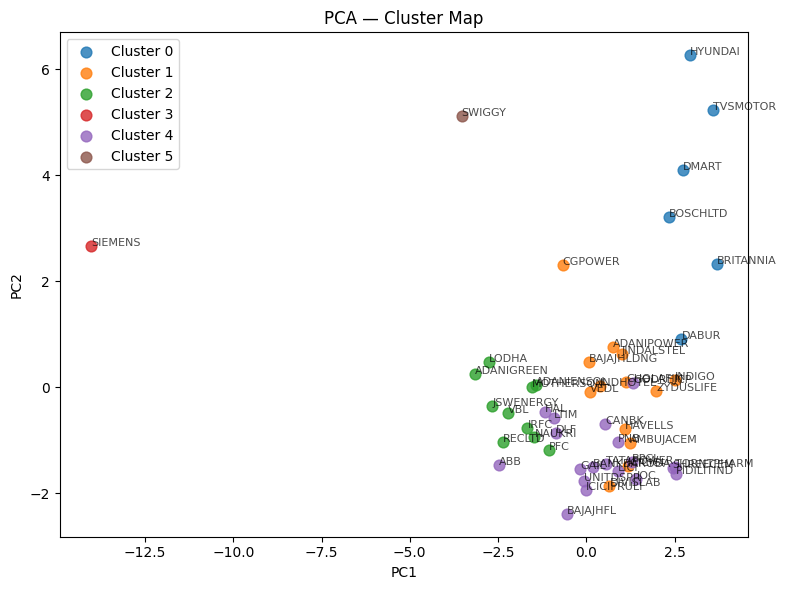

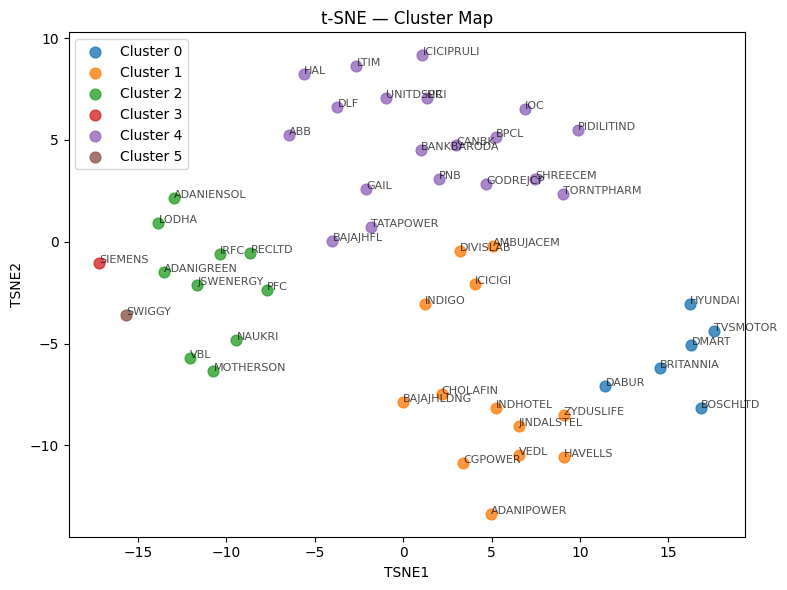

In [21]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(Xrs)
pc_df = pd.DataFrame(pc, index=feature_df.index, columns=["PC1","PC2"])
pc_df["Cluster"] = labels

plt.figure(figsize=(8,6))
for cl in sorted(set(labels)):
    mask = pc_df["Cluster"] == cl
    plt.scatter(pc_df.loc[mask, "PC1"], pc_df.loc[mask, "PC2"], label=f"Cluster {cl}", s=60, alpha=0.8)
for sym, (x, y) in pc_df[["PC1","PC2"]].iterrows():
    plt.text(x, y, sym.split(".")[0], fontsize=8, alpha=0.7)
plt.title("PCA — Cluster Map")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE (optional; can be slow)
try:
    perplexity = min(10, max(5, len(Xrs)//5))
    tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=perplexity, random_state=42)
    ts = tsne.fit_transform(Xrs)
    ts_df = pd.DataFrame(ts, index=feature_df.index, columns=["TSNE1","TSNE2"])
    ts_df["Cluster"] = labels

    plt.figure(figsize=(8,6))
    for cl in sorted(set(labels)):
        mask = ts_df["Cluster"] == cl
        plt.scatter(ts_df.loc[mask, "TSNE1"], ts_df.loc[mask, "TSNE2"], label=f"Cluster {cl}", s=60, alpha=0.8)
    for sym, (x, y) in ts_df[["TSNE1","TSNE2"]].iterrows():
        plt.text(x, y, sym.split(".")[0], fontsize=8, alpha=0.7)
    plt.title("t-SNE — Cluster Map")
    plt.xlabel("TSNE1")
    plt.ylabel("TSNE2")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[INFO] Skipping t-SNE:", e)



## 10. Indicator Distributions by Cluster (matplotlib)

One chart per feature to inspect variation across clusters.


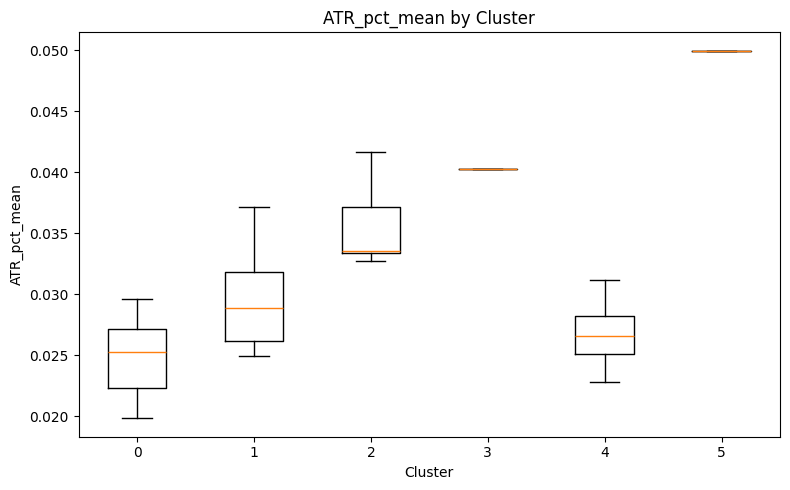

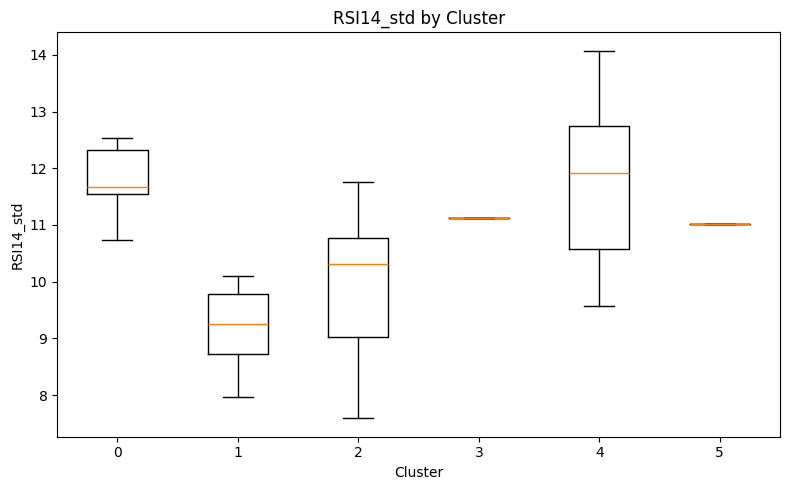

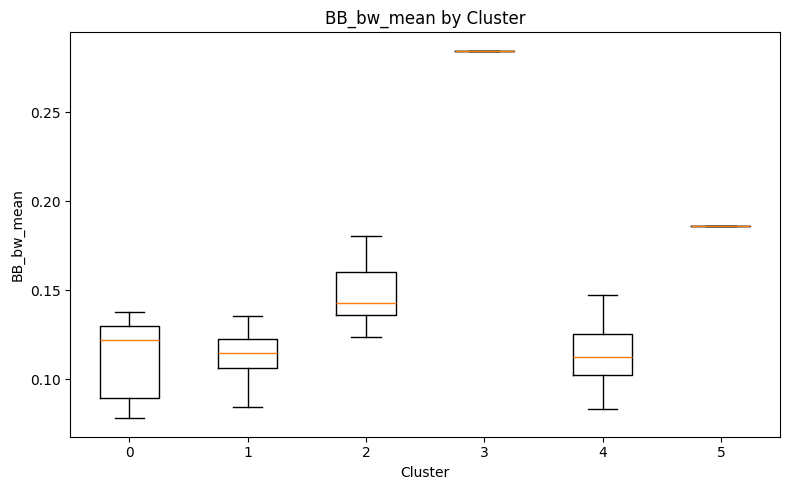

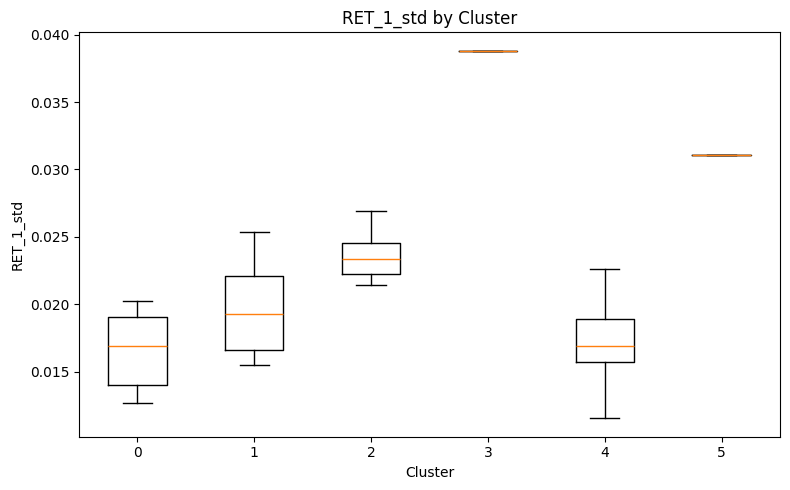

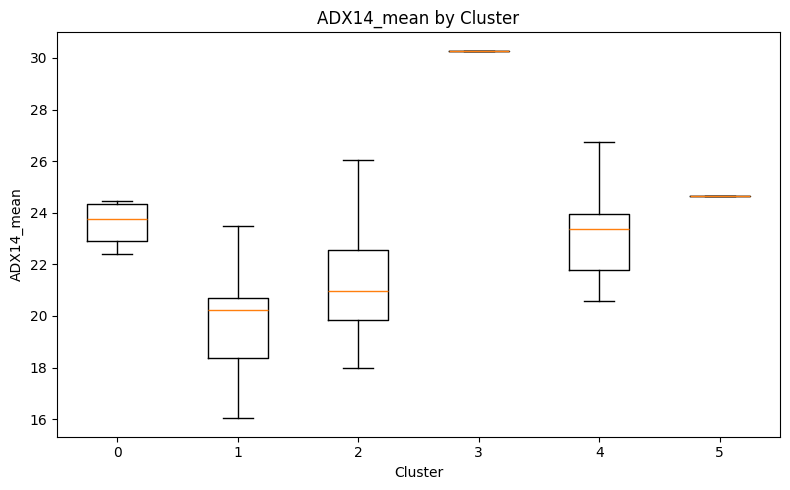

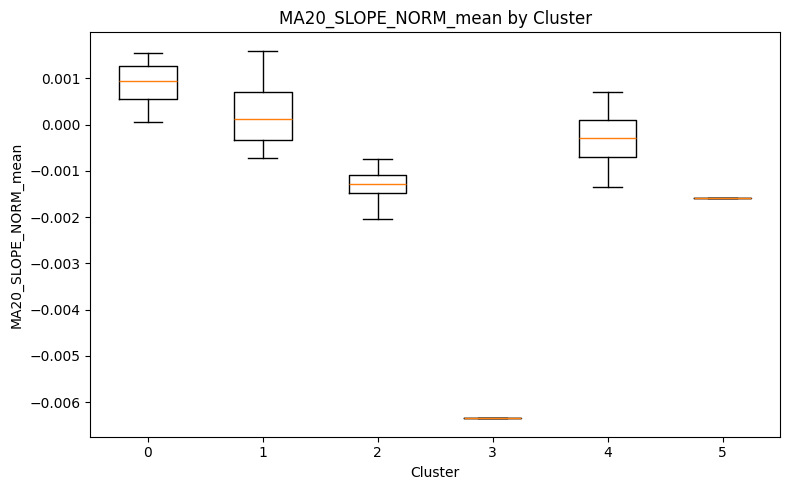

In [22]:

plot_cols = ["ATR_pct_mean","RSI14_std","BB_bw_mean","RET_1_std","ADX14_mean","MA20_SLOPE_NORM_mean"]
plot_df = feature_df.reset_index().rename(columns={"index":"Stock"})[["Stock","Cluster"] + plot_cols]

for feat in plot_cols:
    plt.figure(figsize=(8,5))
    data_by_cluster = [plot_df.loc[plot_df["Cluster"]==cl, feat].dropna().values for cl in sorted(plot_df["Cluster"].unique())]
    # Boxplot per cluster for this feature
    plt.boxplot(data_by_cluster, labels=[str(cl) for cl in sorted(plot_df["Cluster"].unique())], showfliers=False)
    plt.title(f"{feat} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()



## 11. Notes & Next Steps

- This clustering is **behavioral**, not predictive. Use the resulting CSV to **scan/focus** your swing screeners and then apply your **own entry/exit rules**.
- Tune:
  - `LOOKBACK_DAYS` (e.g., 120–240)
  - KMeans `N_CLUSTERS` or DBSCAN `EPS/MIN_SAMPLES`
  - The **composite `swing_score`** weights inside `score_clusters()`
- Extend features (e.g., historical volatility, rolling ADX percentiles, squeeze detection, reversal rates).
- Add a **post-filter** step to select stocks that recently **entered** favorable regimes (e.g., BB squeeze breakout, RSI divergence, MA crossover with ATR above median, etc.).
- For intraday work, repeat the same process on **lower timeframes** (5-min/15-min) and separate clustering per timeframe.
